In [2]:
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Get the list of files in the model folder
model_folder = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/'
model_files = os.listdir(model_folder)

model_logic = pd.DataFrame()

for i in model_files:
    logic = pd.read_csv(model_folder + i, index_col=0, header = None)
    logic.columns = [i.split('.')[0]]
    model_logic = pd.concat([model_logic, logic], axis = 1, ignore_index=False)
model_logic.index.name = None
model_logic = model_logic.transpose()

In [4]:
import numpy as np

# Calculate the weighted similarity distance
def weighted_similarity_distance(row1, row2, weights):
    similarity = row1 == row2
    similarity = similarity.replace({True :0,False:1})
    return np.sum(similarity*(weights))

# Convert distance matrix into lower triangle format for tree reconstruction
def to_lower_triangle(matrix):
    """
    Convert a square distance matrix to a lower triangle format.
    
    Args:
    matrix (np.array): A square numpy array representing the distance matrix.
    
    Returns:
    list: A list of lists representing the lower triangle of the distance matrix.
    """
    n = len(matrix)
    lower_triangle = []
    
    for i in range(n):
        row = []
        for j in range(i + 1):
            row.append(matrix[i][j])
        lower_triangle.append(row)
    
    return lower_triangle

In [21]:
# Create distance matrix from model_logic data
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic.columns)

# Calculate weights (inverse of the number of categories)
category_counts = model_logic.nunique()
weights = 1 / category_counts
weights_array = weights.values

# Create the distance matrix
num_samples = len(encoded_df)
distance_matrix = np.zeros((num_samples, num_samples))

# For loop to calculate the distances
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        dist = weighted_similarity_distance(encoded_df.iloc[i], encoded_df.iloc[j], weights_array)
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

distance_matrix = pd.DataFrame(distance_matrix)
distance_matrix.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/InvasionModels_logic_distancemtx.csv')

In [22]:
distance_matrix

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0.000000,0.631194,0.799858,0.486143,0.282236,0.547861,0.623238,0.648238,0.539905,0.278823,...,0.623238,0.623238,0.421125,0.532236,0.799858,0.342682,0.278823,0.852490,0.898238,0.322861
1,0.631194,0.000000,1.244302,0.785995,0.373920,0.712778,0.307762,0.206026,0.779984,0.869566,...,0.307762,0.196651,0.851709,0.728403,1.244302,0.900470,0.881194,1.296934,0.456026,0.487778
2,0.799858,1.244302,0.000000,0.910969,0.910969,0.910969,1.244302,1.244302,0.910969,0.799858,...,1.244302,1.244302,0.910969,0.910969,0.208747,0.799858,0.799858,0.433144,1.244302,0.910969
3,0.486143,0.785995,0.910969,0.000000,0.468286,0.313772,0.930588,0.889963,0.347254,0.236143,...,0.930588,0.930588,0.204953,0.329397,0.910969,0.195518,0.236143,0.963601,0.639963,0.538772
4,0.282236,0.373920,0.910969,0.468286,0.000000,0.393364,0.641095,0.554984,0.446651,0.532236,...,0.641095,0.529984,0.514379,0.391072,0.910969,0.582762,0.520608,0.963601,0.804984,0.181697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.342682,0.900470,0.799858,0.195518,0.582762,0.317137,0.898238,0.857613,0.314905,0.092682,...,0.898238,0.888337,0.221651,0.332762,0.799858,0.000000,0.092682,0.852490,0.607613,0.542137
1021,0.278823,0.881194,0.799858,0.236143,0.520608,0.297861,0.873238,0.898238,0.289905,0.016628,...,0.873238,0.873238,0.158929,0.282236,0.799858,0.092682,0.000000,0.852490,0.648238,0.572861
1022,0.852490,1.296934,0.433144,0.963601,0.963601,0.963601,1.296934,1.296934,0.963601,0.852490,...,1.296934,1.296934,0.963601,0.963601,0.455188,0.852490,0.852490,0.000000,1.296934,0.963601
1023,0.898238,0.456026,1.244302,0.639963,0.804984,0.539359,0.453793,0.289862,0.402193,0.648238,...,0.453793,0.342682,0.666095,0.554984,1.244302,0.607613,0.648238,1.296934,0.000000,0.764359


In [23]:
import numpy as np
import pandas as pd
import scipy
import Bio
from scipy.cluster.hierarchy import linkage, to_tree
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio import Phylo

# Define your distance matrix (example)
model_labels = list(model_logic.index)
distance_matrix = to_lower_triangle(np.array(distance_matrix))

# Convert the numpy array to a biopython DistanceMatrix
dm = DistanceMatrix(model_labels, matrix = distance_matrix)

# Use the DistanceTreeConstructor to construct the tree
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

# Draw the tree
#Phylo.draw(tree)

# Print the tree in Newick format
#Phylo.write(tree, "./test_phylogenetic_tree.newick", "newick")

In [27]:
tree

TypeError: 'NoneType' object is not callable

In [19]:
from Bio import Phylo
load_tree = Phylo.read('./test_phylogenetic_tree.newick', "newick")
load_tree

Tree(rooted=False, weight=1.0)

In [2]:
from ete3 import Tree, TreeStyle

t = Tree("./test_phylogenetic_tree.newick", format = 1)

In [3]:
ts = TreeStyle()
ts.show_leaf_name = False
ts.mode = 'c'
ts.arc_start = -180
ts.arc_span = 180
t.render('mytree.png', w = 1000, h = 1000, units = 'mm', tree_style=ts)

{'nodes': [[1457.7162832126062,
   1604.1542780791963,
   1463.2098800604463,
   1609.5686178455178,
   0,
   None],
  [753.6341284084925,
   1744.0487899146465,
   757.7835861883,
   1748.1383827421062,
   1,
   None],
  [1200.7723843434399,
   1103.0568011334985,
   1206.6274774933431,
   1108.8274218315755,
   2,
   None],
  [777.6202369900735,
   1608.2046259026354,
   782.3004892033365,
   1612.8173552995233,
   3,
   None],
  [676.5721965118,
   1733.2873480303297,
   680.7628210669875,
   1737.4175137129089,
   4,
   None],
  [604.1387082790216,
   1737.870944318154,
   608.3103843067726,
   1741.9824348470124,
   5,
   None],
  [456.0297967526481,
   1740.0707553676314,
   460.19196536137525,
   1744.1728756426614,
   6,
   None],
  [574.4425835314918,
   1734.998777272046,
   578.6237448914694,
   1739.1196162865858,
   7,
   None],
  [452.9289599303742,
   1736.0739514396605,
   457.10380019210504,
   1740.1885605515424,
   8,
   None],
  [452.95362576908644,
   1732.08665489

/home/spankaew/anaconda3/envs/ete3/lib/python3.6/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/ete3/lib/python3.6/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


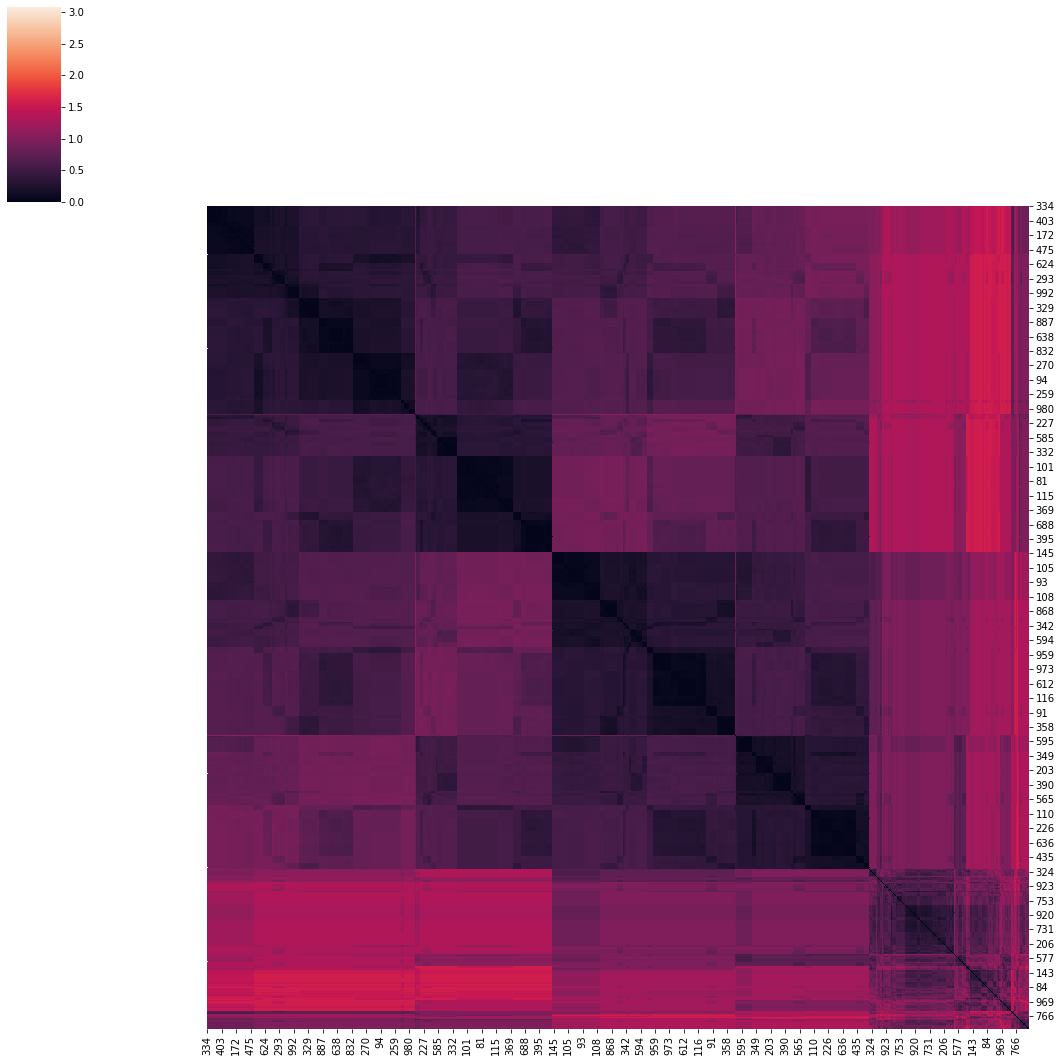

In [5]:
import seaborn as sns

g = sns.clustermap(distance_matrix, figsize = (15,15))

# Hiding the row dendrogram
g.ax_row_dendrogram.set_visible(False)

# Hiding the column dendrogram
g.ax_col_dendrogram.set_visible(False)

plt.show()

ValueError: Length mismatch: Expected axis has 1023 elements, new values have 1024 elements

In [45]:
distance_matrix.index = list(model_logic.index)
distance_matrix.columns = list(model_logic.index)
distance_matrix

,Invasion_532,Invasion_879,Invasion_718,Invasion_988,Invasion_895,Invasion_855,Invasion_115,Invasion_263,Invasion_210,Invasion_581,...,Invasion_43,Invasion_193,Invasion_649,Invasion_741,Invasion_391,Invasion_427,Invasion_571,Invasion_515,Invasion_318,Invasion_799
Invasion_532,0.000000,0.660037,0.817778,0.502051,0.310831,0.576704,0.651855,0.677496,0.568522,0.279136,...,0.651855,0.651855,0.435831,0.560831,0.817778,0.344163,0.279136,0.873333,0.927496,0.352345
Invasion_879,0.660037,0.000000,1.276111,0.801329,0.374485,0.726872,0.336704,0.221472,0.795037,0.898272,...,0.336704,0.211704,0.880091,0.742745,1.276111,0.929805,0.910037,1.331667,0.471472,0.502513
Invasion_718,0.817778,1.276111,0.000000,0.942778,0.942778,0.942778,1.276111,1.276111,0.942778,0.817778,...,1.276111,1.276111,0.942778,0.942778,0.212112,0.817778,0.817778,0.438895,1.276111,0.942778
Invasion_988,0.502051,0.801329,0.942778,0.000000,0.483869,0.342996,0.960384,0.918870,0.377051,0.252051,...,0.960384,0.960384,0.220355,0.358869,0.942778,0.210537,0.252051,0.998333,0.668870,0.567355
Invasion_895,0.310831,0.374485,0.942778,0.483869,0.000000,0.407663,0.670037,0.570678,0.461704,0.560831,...,0.670037,0.545037,0.542649,0.405303,0.942778,0.612345,0.549066,0.998333,0.820678,0.196817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Invasion_427,0.344163,0.929805,0.817778,0.210537,0.612345,0.346472,0.927496,0.885982,0.344163,0.094163,...,0.927496,0.917496,0.237345,0.362345,0.817778,0.000000,0.094163,0.873333,0.635982,0.570831
Invasion_571,0.279136,0.910037,0.817778,0.252051,0.549066,0.326704,0.901855,0.927496,0.318522,0.016790,...,0.901855,0.901855,0.173485,0.310831,0.817778,0.094163,0.000000,0.873333,0.677496,0.602345
Invasion_515,0.873333,1.331667,0.438895,0.998333,0.998333,0.998333,1.331667,1.331667,0.998333,0.873333,...,1.331667,1.331667,0.998333,0.998333,0.461613,0.873333,0.873333,0.000000,1.331667,0.998333
Invasion_318,0.927496,0.471472,1.276111,0.668870,0.820678,0.554805,0.469163,0.290303,0.403386,0.677496,...,0.469163,0.344163,0.695678,0.570678,1.276111,0.635982,0.677496,1.331667,0.000000,0.779164


In [47]:
import scipy
Z = scipy.cluster.hierarchy.linkage(distance_matrix, method='single', metric='euclidean')

/home/spankaew/anaconda3/envs/ete3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


,0,1,2,3
0,310.0,314.0,0.007107,2.0
1,473.0,1024.0,0.007107,3.0
2,893.0,1025.0,0.007107,4.0
3,239.0,387.0,0.007107,2.0
4,430.0,1027.0,0.007107,3.0
...,...,...,...,...
1018,2010.0,2040.0,7.162260,281.0
1019,2021.0,2039.0,7.185167,571.0
1020,2041.0,2042.0,7.290630,452.0
1021,2043.0,2044.0,9.805789,1023.0


In [52]:
Z

array([[0.        , 1.        , 0.1       , 2.        ],
       [2.        , 4.        , 0.3       , 3.        ],
       [3.        , 5.        , 0.46666667, 4.        ]])

In [85]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Example distance matrix
D = distance_matrix

# Perform hierarchical clustering using the linkage method
# 'average' is one of the linkage methods; other methods include 'single', 'complete', 'ward', etc.
Z = linkage(D, method='single')

# Plot the dendrogram to visualize the clustering
#plt.figure(figsize=(10, 5))
#dendrogram(Z)
#plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('Sample Index')
#plt.ylabel('Distance')
#plt.show()

# Optional: Cut the dendrogram to form flat clusters
# The number of clusters can be set by specifying a distance threshold or the desired number of clusters
max_d = 5  # Maximum distance threshold to form clusters
clusters = fcluster(Z, max_d, criterion='distance')

# Print the resulting cluster assignments
#print("Cluster assignments:", clusters)

/home/spankaew/anaconda3/envs/ete3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


In [97]:
cluster_dict = {8:'cluster0',
                1:'cluster1',
                4:'cluster2',
                6:'cluster3',
                2:'cluster4',
                11:'clustersX',
                3:'clustersX',
                14:'clustersX',
                9:'clustersX',
                15:'clustersX',
                13:'clustersX',
                16:'clustersX',
                12:'clustersX',
                10:'clustersX',
                7:'clustersX',
                5:'clustersX'}

In [98]:
# Assign clusters to model
clusters = pd.DataFrame(clusters)
clusters.index = list(model_logic.index)
clusters.columns = ['clusters']

# Add clusters info to model_logic
model_logic['logic_cluster'] = clusters.clusters.replace(cluster_dict)

In [101]:
cluster_name = list(model_logic['logic_cluster'].unique())

In [103]:
var_logic_clust = pd.DataFrame()
for i in cluster_name:
    model_logic_sub = model_logic.loc[model_logic.logic_cluster == i]
    model_logic_sub = model_logic_sub.drop(['logic_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = cluster_name

In [114]:
var_logic_clust

,cluster1,cluster0,cluster2,cluster4,clustersX,cluster3
AKT1,10,10,65,7,20,9
AKT2,52,53,64,57,26,42
Apoptosis,5,7,79,6,24,5
CDH1,2,2,46,2,19,2
CDH2,1,1,1,1,1,1
CTNNB1,2,2,32,2,15,2
CellCycleArrest,1,1,51,1,22,1
DKK1,1,1,1,1,2,1
DNAdamage,1,1,1,1,1,1
ECMicroenv,1,1,1,1,1,1


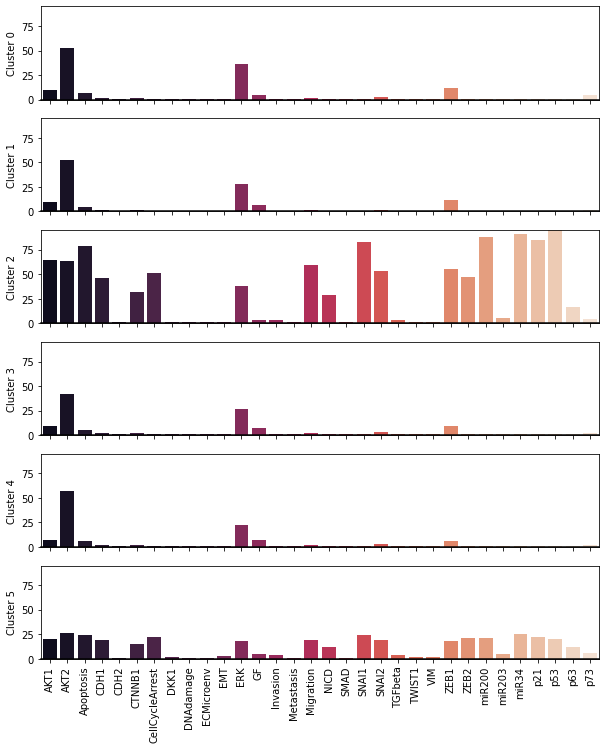

In [116]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 12), sharex=True)
plt.ylim(0,65)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust['cluster0'], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Cluster 0")
#ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust['cluster1'], palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Cluster 1")
#ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust['cluster2'], palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Cluster 2")
#ax3.bar_label(ax3.containers[0], fontsize=10)
ax3.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust['cluster3'], palette="rocket", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("Cluster 3")
#ax4.bar_label(ax4.containers[0], fontsize=10)
ax4.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust['cluster4'], palette="rocket", ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_ylabel("Cluster 4")
#ax5.bar_label(ax5.containers[0], fontsize=10)
ax5.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust['clustersX'], palette="rocket", ax=ax6)
ax6.axhline(0, color="k", clip_on=False)
ax6.set_ylabel("Cluster X")
#ax6.bar_label(ax6.containers[0], fontsize=10)
ax6.set_ylim(0,95)

plt.xticks(rotation = 90)
plt.show()